In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import scipy.stats as stats

# Disable warnings
warnings.filterwarnings('ignore')

In [2]:
# General settings
figure_path = "./figures/main/"

# Seaborn settings
sns.set_palette(sns.color_palette("magma"))
sns.set_style("ticks")
sns.set_style({'font.family': 'Lato'})
sns.set_context("paper", font_scale = 1.8)

## Figure 6

In [3]:
# Decide if you want to filter out images with label errors
filter_errors = True # Either: False (do not filter) or True (do filter)

# Set random seed
np.random.seed(1312)

In [4]:
# Load experimental result file
file_path = "./data/"
file = pd.ExcelFile(file_path + "experiment_two_results.ods", engine="odf")

# Build dict from file
dfs = {ind: file.parse(sheet_name, header=None) 
          for ind, sheet_name in enumerate(file.sheet_names)}

# Pre-allocate array
arr = np.zeros((len(dfs),dfs[0].shape[0],dfs[0].shape[1]+3), dtype=float)

# Load item order and indices and model accuracy
order = np.load(file_path + "order.npy")
indices = np.int64(np.load(file_path + "indices.npy", allow_pickle=True)[6:])
mean_decisions_correct = np.load(file_path + "Rebuttal_mean_decisions_correct.npy")  
label_error = np.load(file_path + "label_errors.npy", allow_pickle=True)

# Build array from dict by looping through the sheets
for ind in range(len(dfs)):
    arr[ind,:,0:3] = dfs[ind]
    arr[ind,:,3] = order
    arr[ind,:,4] = indices
    arr[ind,:,5] = mean_decisions_correct[indices].flatten()

In [5]:
# Filter label errors if flag is set
if filter_errors:
    
    # Get error indices from MTURK labeled errors
    error_inds = np.where(label_error[indices] == 1)[0]
    
    # Remove items 44, 222, and 254 and label error indices
    arr_corrected = np.delete(arr, np.concatenate((error_inds, [43, 221, 253])), axis=1)
    
    # Make all categories have the same amount of images
    impossible_inds = np.where(arr_corrected[0,:,3] == 0)[0]
    inbetween_inds = np.where(arr_corrected[0,:,3] == 1)[0]
    trivial_inds = np.where(arr_corrected[0,:,3] == 2)[0]
    
    # Randomly pull indices which should be removed from trivials and impossibles to equal out number of images
    rm_inds_inbetween = np.random.choice(inbetween_inds, len(inbetween_inds) - len(impossible_inds), replace=False)
    rm_inds_trivial = np.random.choice(trivial_inds, len(trivial_inds) - len(impossible_inds), replace=False)
    
    # Equal out number of images for all categories
    arr_corrected = np.delete(arr_corrected, np.concatenate((rm_inds_inbetween, rm_inds_trivial)), axis=1)
    
else:
    
    # Remove items 44, 222, and 254 (indices 43, 221, 253)
    arr_corrected = np.delete(arr, [43, 221, 253], axis=1)

# Get trivial, impossible and in-between indeces
impossible_inds = np.where(arr_corrected[0,:,3] == 0)
inbetween_inds = np.where(arr_corrected[0,:,3] == 1)
trivial_inds = np.where(arr_corrected[0,:,3] == 2)

In [6]:
# To check whether indexing has worked, print accuracies of the three model classes
print(f"Impossible items have a mean accuracy of {np.mean(arr_corrected[0,impossible_inds,5]):.4}")
print(f"Inbetween items have a mean accuracy of {np.mean(arr_corrected[0,inbetween_inds,5]):.4}")
print(f"Trivial items have a mean accuracy of {np.mean(arr_corrected[0,trivial_inds,5]):.4}")

Impossible items have a mean accuracy of 0.0
Inbetween items have a mean accuracy of 0.6874
Trivial items have a mean accuracy of 1.0


findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


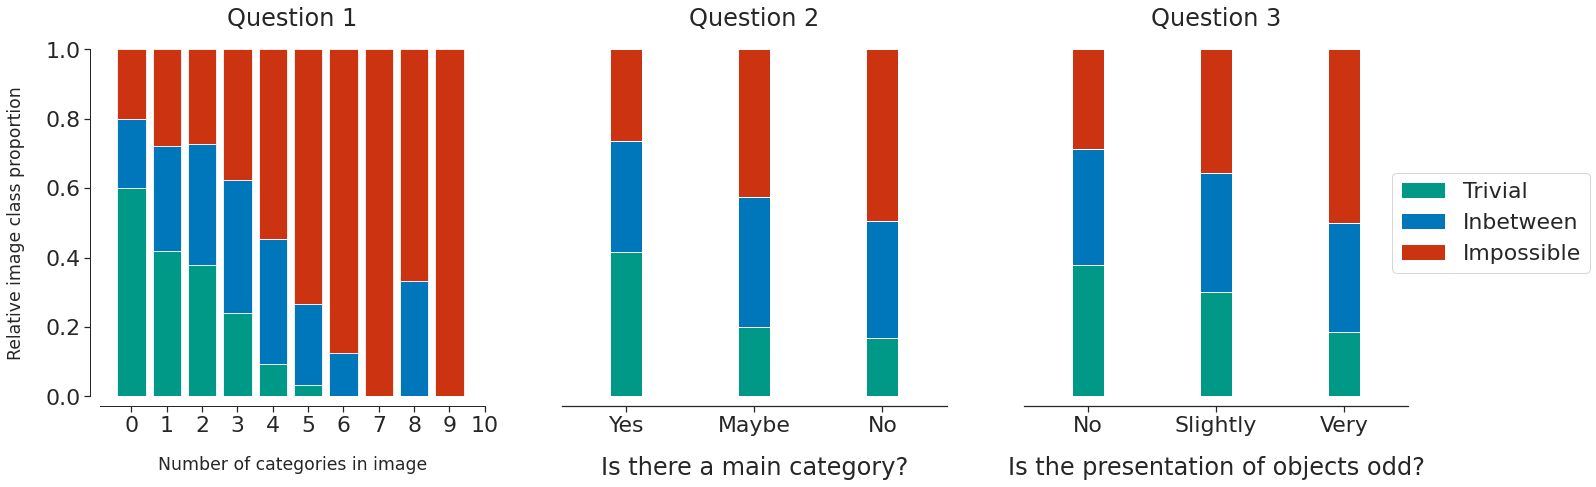

In [7]:
# Figure size and title
fig = plt.figure(figsize=(40,60))
counter = 1

# Loop through questions (see why shape[2]-1 in KDE plot loop above)
for question in range(3):

    # Make subplot for each question
    ax = fig.add_subplot(arr_corrected.shape[0], arr_corrected.shape[2]-1, counter)
    counter+= 1

    # Get count and label arrays
    if question == 0:
        trivial_counts, trivial_labels = np.histogram(arr_corrected[:, trivial_inds, question], 
                                                      bins=10, range=[0,10])
        inbetween_counts, inbetween_labels = np.histogram(arr_corrected[:, inbetween_inds, question], 
                                                          bins=10, range=[0,10])
        impossible_counts, impossible_labels = np.histogram(arr_corrected[:, impossible_inds, question], 
                                                            bins=10, range=[0,10])
    else:
        trivial_counts, trivial_labels = np.histogram(arr_corrected[:, trivial_inds, question], 
                                                      bins=3, range=[0,3])
        inbetween_counts, inbetween_labels = np.histogram(arr_corrected[:, inbetween_inds, question], 
                                                          bins=3, range=[0,3])
        impossible_counts, impossible_labels = np.histogram(arr_corrected[:, impossible_inds, question], 
                                                            bins=3, range=[0,3])

    # Transform counts into floats
    trivial_counts = np.float64(trivial_counts)
    inbetween_counts = np.float64(inbetween_counts)
    impossible_counts = np.float64(impossible_counts)

    # Calculate total counts for each category and norm all answers to this
    for options in range(trivial_counts.shape[0]):
        total_counts = trivial_counts[options] + inbetween_counts[options] + impossible_counts[options]
        trivial_counts[options] = trivial_counts[options] / total_counts 
        inbetween_counts[options] = inbetween_counts[options] / total_counts 
        impossible_counts[options] = impossible_counts[options] / total_counts 
    
    # Make plots
    if question == 0:
        ax.bar(trivial_labels[:-1], trivial_counts, label='Trivial',
               color='#009988')
        ax.bar(inbetween_labels[:-1], inbetween_counts, label='Inbetween', 
               bottom=trivial_counts, color='#0077bb')
        ax.bar(impossible_labels[:-1], impossible_counts, label='Impossible', 
               bottom=trivial_counts+inbetween_counts, color='#cc3311')

    # Scale width of bars for questions 2 and 3
    else:
        ax.bar(trivial_labels[:-1], trivial_counts, label='Trivial',
               color='#009988', width=0.25)
        ax.bar(inbetween_labels[:-1], inbetween_counts, label='Inbetween', 
               bottom=trivial_counts, color='#0077bb', width=0.25)
        ax.bar(impossible_labels[:-1], impossible_counts, label='Impossible', 
               bottom=trivial_counts+inbetween_counts, color='#cc3311', width=0.25)

    # General settings for all plots
    sns.despine(offset=20)
    sns.set_context(context="notebook", font_scale=2)
    plt.ylim(0, 1.0)

    # Set individual x labels and limits
    if question == 0:
        plt.xticks(np.arange(0,11,1), np.arange(0,11,1), ha="center")
        plt.xlabel("Number of categories in image", labelpad=20)
        plt.ylabel("Relative image class proportion", labelpad=20)

    elif question == 1:
        plt.xlim(2.5,-0.5)
        plt.xticks([2,1,0], ["Yes", "Maybe", "No"])
        plt.xlabel("Is there a main category?", labelpad=20)
        y_axis = ax.axes.get_yaxis()
        y_axis.set_visible(False)
        ax.spines['left'].set_color("w")

    elif question == 2:
        plt.xlim(-0.5,2.5)
        plt.xticks([0,1,2], ["No", "Slightly", "Very"])
        plt.xlabel("Is the presentation of objects odd?", labelpad=20)
        y_axis = ax.axes.get_yaxis()
        y_axis.set_visible(False)
        ax.spines['left'].set_color("w")

    # Only show legend in upmost right plot
    if question == 2:
        plt.legend(loc="center right", bbox_to_anchor=(1.0, 0.25, 0.5, 0.5))
        
    # Only plot question index above first row of plots
    plt.title(f"Question {question+1}", y=1.05)

# Figure aesthetics and saving
sns.despine(offset=10)
sns.set_context(context="notebook", font_scale=2)

# Save figure
plt.savefig(figure_path + 'figure_6.png', dpi=300, bbox_inches='tight')